In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/sales/'
df_train = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [ ]:
#時系列データの変換
df_train['date'] = pd.to_datetime(df_train['date'], format="%Y-%m-%d %H:%M:%S")
df_train['day'] = df_train['date'].dt.day
df_train['month'] = df_train['date'].dt.month
df_train['dayofweek'] = df_train['date'].dt.dayofweek
df_train['year'] = df_train['date'].dt.year
df_train.head()

,id,date,store_nbr,family,sales,onpromotion,day,month,dayofweek,year
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,1,1,2013
1,1,2013-01-01,1,BABY CARE,0.0,0,1,1,1,2013
2,2,2013-01-01,1,BEAUTY,0.0,0,1,1,1,2013
3,3,2013-01-01,1,BEVERAGES,0.0,0,1,1,1,2013
4,4,2013-01-01,1,BOOKS,0.0,0,1,1,1,2013


In [ ]:
#カテゴリ変数に変換
df_train['family'].value_counts()
df_train.groupby('family').sum()

,id,store_nbr,sales,onpromotion
family,,,,
AUTOMOTIVE,136442875140,2500740,5.548220e+05,4783
BABY CARE,136442966076,2500740,1.005100e+04,53
BEAUTY,136443057012,2500740,3.378930e+05,13483
BEVERAGES,136443147948,2500740,2.169545e+08,906958
BOOKS,136443238884,2500740,6.438000e+03,0
BREAD/BAKERY,136443329820,2500740,4.213395e+07,331289
CELEBRATION,136443420756,2500740,7.611770e+05,6723
CLEANING,136443511692,2500740,9.752129e+07,661157
DAIRY,136443602628,2500740,6.448771e+07,728707


In [ ]:
#ラベルエンコーディング
from sklearn.preprocessing import LabelEncoder

feature = ['family']
for col in feature:
  lbl = LabelEncoder()
  df_train[col] = lbl.fit_transform(df_train[col].values)

df_train.groupby('family').sum() 

,id,store_nbr,sales,onpromotion,day,month,dayofweek,year
family,,,,,,,,
0,136442875140,2500740,5.548220e+05,4783,1421334,564516,272538,183221298
1,136442966076,2500740,1.005100e+04,53,1421334,564516,272538,183221298
2,136443057012,2500740,3.378930e+05,13483,1421334,564516,272538,183221298
3,136443147948,2500740,2.169545e+08,906958,1421334,564516,272538,183221298
4,136443238884,2500740,6.438000e+03,0,1421334,564516,272538,183221298
5,136443329820,2500740,4.213395e+07,331289,1421334,564516,272538,183221298
6,136443420756,2500740,7.611770e+05,6723,1421334,564516,272538,183221298
7,136443511692,2500740,9.752129e+07,661157,1421334,564516,272538,183221298
8,136443602628,2500740,6.448771e+07,728707,1421334,564516,272538,183221298


In [ ]:
df_train

,id,date,store_nbr,family,sales,onpromotion,day,month,dayofweek,year
0,0,2013-01-01,1,0,0.000,0,1,1,1,2013
1,1,2013-01-01,1,1,0.000,0,1,1,1,2013
2,2,2013-01-01,1,2,0.000,0,1,1,1,2013
3,3,2013-01-01,1,3,0.000,0,1,1,1,2013
4,4,2013-01-01,1,4,0.000,0,1,1,1,2013
...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,28,438.133,0,15,8,1,2017
3000884,3000884,2017-08-15,9,29,154.553,1,15,8,1,2017
3000885,3000885,2017-08-15,9,30,2419.729,148,15,8,1,2017
3000886,3000886,2017-08-15,9,31,121.000,8,15,8,1,2017


In [ ]:
#テストデータも変換
feature = ['family']
for col in feature:
  lbl = LabelEncoder()
  df_test[col] = lbl.fit_transform(df_test[col].values)

df_test.groupby('family').sum() 

,id,store_nbr,onpromotion
family,,,
0,2605070160,23760,19
1,2605071024,23760,1
2,2605071888,23760,698
3,2605072752,23760,22381
4,2605073616,23760,0
5,2605074480,23760,10090
6,2605075344,23760,27
7,2605076208,23760,14834
8,2605077072,23760,20457


In [ ]:
df_test['date'] = pd.to_datetime(df_test['date'], format="%Y-%m-%d %H:%M:%S")
df_test['day'] = df_test['date'].dt.day
df_test['month'] = df_test['date'].dt.month
df_test['dayofweek'] = df_test['date'].dt.dayofweek
df_test['year'] = df_test['date'].dt.year


In [ ]:
df_test

,id,date,store_nbr,family,onpromotion,day,month,dayofweek,year
0,3000888,2017-08-16,1,0,0,16,8,2,2017
1,3000889,2017-08-16,1,1,0,16,8,2,2017
2,3000890,2017-08-16,1,2,2,16,8,2,2017
3,3000891,2017-08-16,1,3,20,16,8,2,2017
4,3000892,2017-08-16,1,4,0,16,8,2,2017
...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,28,1,31,8,3,2017
28508,3029396,2017-08-31,9,29,0,31,8,3,2017
28509,3029397,2017-08-31,9,30,1,31,8,3,2017
28510,3029398,2017-08-31,9,31,9,31,8,3,2017


In [ ]:
#モデルを作る
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [ ]:
X = df_train.drop(columns=['id', 'date','sales'])
y = df_train['sales']
X

,store_nbr,family,onpromotion,day,month,dayofweek,year
0,1,0,0,1,1,1,2013
1,1,1,0,1,1,1,2013
2,1,2,0,1,1,1,2013
3,1,3,0,1,1,1,2013
4,1,4,0,1,1,1,2013
...,...,...,...,...,...,...,...
3000883,9,28,0,15,8,1,2017
3000884,9,29,1,15,8,1,2017
3000885,9,30,148,15,8,1,2017
3000886,9,31,8,15,8,1,2017


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0,shuffle=True)


In [ ]:
params = {
    'silent': 1,
    'max_depth': 6,
    'min_child_weight': 1,
    'eta': 0.1,
    'tree_method': 'exact',
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'predictor': 'cpu_predictor'
}
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test,label=y_test)
model = xgb.train(params=params,
                  dtrain=dtrain,
                  num_boost_round=1000,
                  early_stopping_rounds=5,
                  evals=[(dtest, 'test')])

[0]	test-rmse:1079.73
Will train until test-rmse hasn't improved in 5 rounds.
[1]	test-rmse:1012.8
[2]	test-rmse:953.744
[3]	test-rmse:902.114
[4]	test-rmse:853.884
[5]	test-rmse:817.131
[6]	test-rmse:784.313
[7]	test-rmse:750.447
[8]	test-rmse:725.39
[9]	test-rmse:700.725
[10]	test-rmse:683.125
[11]	test-rmse:666.739
[12]	test-rmse:649.409
[13]	test-rmse:636.072
[14]	test-rmse:624.926
[15]	test-rmse:615.721
[16]	test-rmse:603.836
[17]	test-rmse:594.555
[18]	test-rmse:583.135
[19]	test-rmse:577.756
[20]	test-rmse:569.736
[21]	test-rmse:565.818
[22]	test-rmse:558.906
[23]	test-rmse:552.085
[24]	test-rmse:546.017
[25]	test-rmse:540.742
[26]	test-rmse:537.582
[27]	test-rmse:532.357
[28]	test-rmse:528.299
[29]	test-rmse:525.586
[30]	test-rmse:521.959
[31]	test-rmse:519.883
[32]	test-rmse:514.117
[33]	test-rmse:508.193
[34]	test-rmse:503.512
[35]	test-rmse:500.409
[36]	test-rmse:498.579
[37]	test-rmse:495.07
[38]	test-rmse:493.417
[39]	test-rmse:490.072
[40]	test-rmse:488.374
[41]	test-rmse

In [ ]:
pred = model.predict(xgb.DMatrix(X_test),
                     ntree_limit=model.best_ntree_limit)

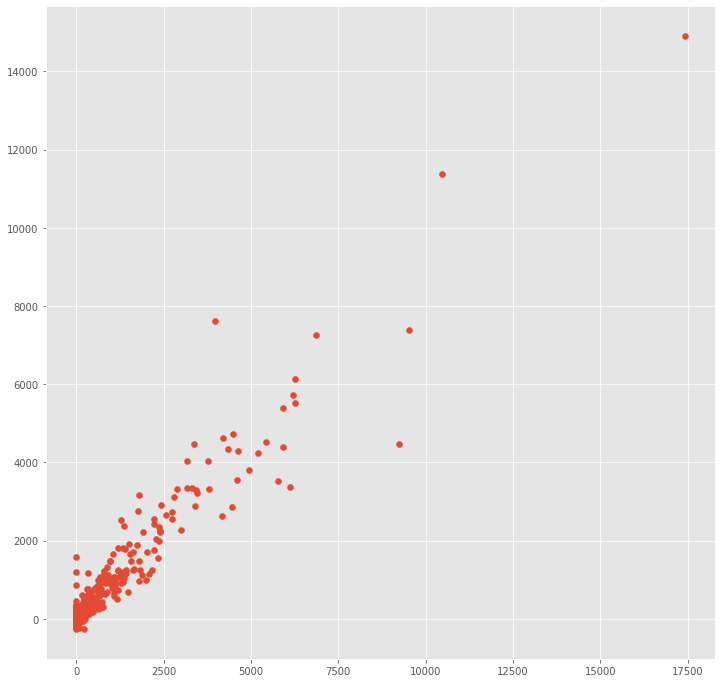

In [ ]:
plt.figure(figsize=(12, 12))
plt.scatter(y_test[:1000], pred[:1000])
plt.show()

In [ ]:
X_for_submit = df_test[['store_nbr','family','onpromotion','day','month','dayofweek','year']]
submit = df_test[['id']]
submit['sales'] = model.predict(xgb.DMatrix(X_for_submit),
                     ntree_limit=model.best_ntree_limit)
submit

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,id,sales
0,3000888,-7.070646
1,3000889,-9.094426
2,3000890,-56.453888
3,3000891,2259.948486
4,3000892,-30.600422
...,...,...
28507,3029395,350.216431
28508,3029396,84.331322
28509,3029397,1445.742798
28510,3029398,306.759430


In [ ]:
submit.to_csv('/content/drive/MyDrive/sales/submit.csv',index=False)

<function matplotlib.pyplot.show>

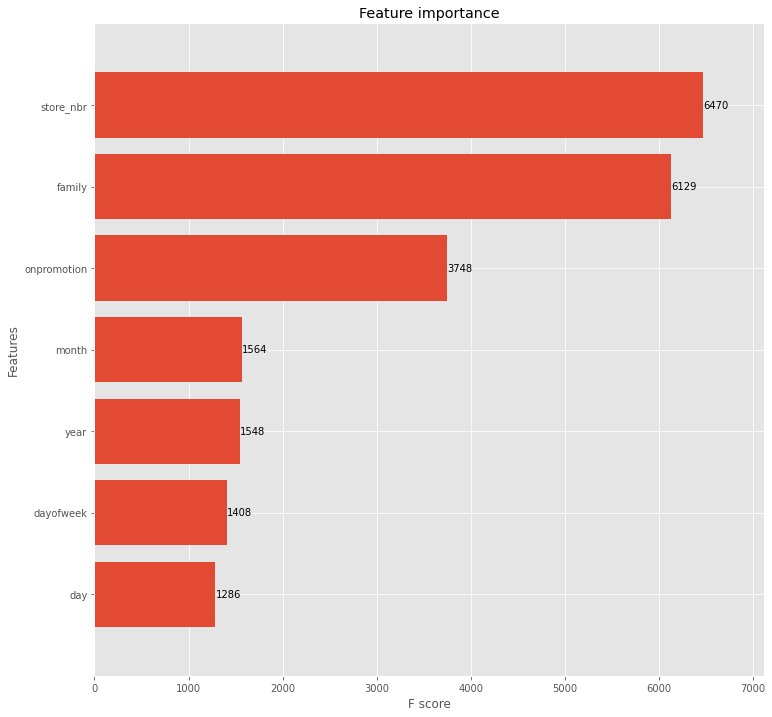

In [ ]:
fig,ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model,max_num_features=12,height=0.8,ax=ax)
plt.show